# GEONE - DEESSE - Basics

## Main points addressed

- launching deesse
- simple deesse simulations of a categorical variable, with hard data points
- basic statistics on the results
- deesse simulation using pyramids (multi-resolution)

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=11, micro=5, releaselevel='final', serial=0)
geone version: 1.2.17


### Remark
The matplotlib figures can be visualized in *interactive* mode:

- `%matplotlib notebook`: enable interactive mode
- `%matplotlib inline`: disable interactive mode

## Training image (TI)

Read the file `ti.txt` using the function `geone.img.readImageTxt` (see jupyter notebook `ex_a_01_image_and_pointset.ipynb` for details).

In [3]:
data_dir = 'data' # directory containing the training image file
filename = os.path.join(data_dir, 'ti.txt')
ti = gn.img.readImageTxt(filename)
ti

*** Img object ***
name = 'data/ti.txt'
(nx, ny, nz) = (300, 250, 1) # number of cells along each axis
(sx, sy, sz) = (1.0, 1.0, 1.0) # cell size (spacing) along each axis
(ox, oy, oz) = (0.0, 0.0, 0.0) # origin (coordinates of bottom-lower-left corner)
nv = 1  # number of variable(s)
varname = ['code']
val: (1, 1, 250, 300)-array
*****

In [4]:
# Values taken in ti
ti.get_unique()

array([0., 1., 2.])

Plot the image using the function `geone.imgplot.drawImage2D` (see jupyter notebook `ex_a_01_image_and_pointset.ipynb` for details).

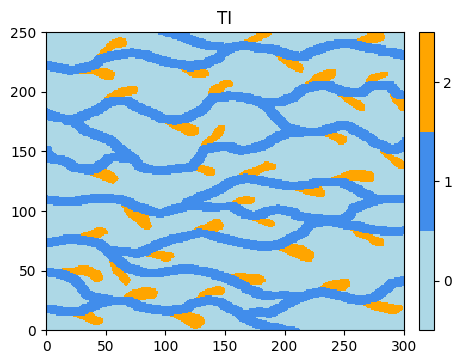

In [5]:
# Define category values and colors
categ_val = [0, 1, 2]
categ_col = ['lightblue', [x/255. for x in ( 65, 141, 235)], 'orange']

plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(ti, categ=True, categVal=categ_val, categCol=categ_col)
plt.title('TI')
plt.show()

## Simulation grid
Define the simulation grid (number of cells in each direction, cell unit, origin).

In [6]:
nx, ny, nz = 100, 100, 1         # number of cells
sx, sy, sz = ti.sx, ti.sy, ti.sz # cell unit
ox, oy, oz = 0.0, 0.0, 0.0       # origin (corner of the "first" grid cell)

## Hard data (point set)

Read the file `hd.txt` using the function `geone.img.readPointSetTxt` (see jupyter notebook `ex_a_01_image_and_pointset.ipynb` for details).

In [7]:
data_dir = 'data'
filename = os.path.join(data_dir, 'hd.txt')
hd = gn.img.readPointSetTxt(filename)
hd

*** PointSet object ***
name = ''
npt = 7 # number of point(s)
nv = 4  # number of variable(s) (including coordinates)
varname = ['X', 'Y', 'Z', 'code']
val: (4, 7)-array
*****

In [8]:
hd.val

array([[10.5, 14.5, 60.5, 45.5, 17.5, 52.5, 45.5],
       [20.5, 21.5, 32.5, 55.5, 75.5, 80.5, 97.5],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 2. ,  2. ,  1. ,  0. ,  1. ,  0. ,  0. ]])

The array `hd.val` contains:

- `hd.val[0]`: $x$ coordinates of the points
- `hd.val[1]`: $y$ coordinates of the points
- `hd.val[2]`: $z$ coordinates of the points
- `hd.val[3]`: value of the next variable (stored in the point set)

Plot the hard data points in the simulation grid.

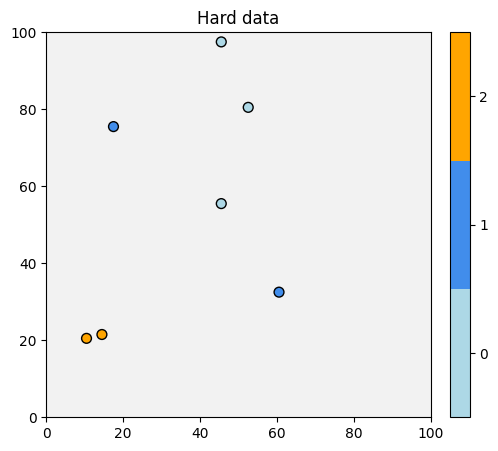

In [9]:
# Get the colors for values of the variable of index 3 in the point set, 
# according to the color settings used for the TI
hd_col = gn.imgplot.get_colors_from_values(hd.val[3], categ=True, categVal=categ_val, categCol=categ_col)

# Set an image with simulation grid geometry defined above, and no variable
im_empty = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=0)

# Plot
plt.figure(figsize=(8,5))

# Plot empty simulation grid and specify colors
gn.imgplot.drawImage2D(im_empty, categ=True, categVal=categ_val, categCol=categ_col)

# Add hard data points
plt.scatter(hd.x(), hd.y(), marker='o', s=50, color=hd_col, edgecolors='black', linewidths=1)

plt.title('Hard data')
plt.show()

## Input structure for deesse (class `geone.deesseinterface.DeesseInput`)
The variable name for the hard data (in `hd.varname`) and for the simulated variable (keyword argument `varname` below) should be the same, otherwise, the hard data will be ignored. Moreover, the hard data locations should be in the simulation grid, which is described by its dimensions (number of cells) in each direction, the cell unit in each direction, and the origin (the *corner* of the grid cell with the minimal x, y, z coordinates). Hard data points out of the simulation grid are ignored.  

The hard data can be passed to deesse through a *point set*, i.e. a class `geone.img.PointSet` (keyword argument `dataPointSet`, as below) or through an *image*, i.e. a class `geone.img.Img` (keyword argument `dataImage`, not illustrated here), and can contain missing (uninformed) data (`nan`).

The type of distance for computing the dissimilarity between patterns is controlled by the keyword argument `distanceType`: 

- `0` or `'categorical'`: proportion of non-matching nodes (default)
- `1` or `'continuous'`: $L_1$ distance
- `2`: $L_2$ distance
- `3`: $L_p$ distance (requires real positive parameter p given in parameter `powerLpDistance`)
- `4` :$L_\infty$ distance

In [10]:
nreal = 20
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,        # dimension of the simulation grid (number of cells)
    sx=sx, sy=sy, sz=sz,        # cells units in the simulation grid
    ox=ox, oy=oy, oz=oz,        # origin of the simulation grid
    nv=1, varname='code',       # number of variable(s), name of the variable(s)
    TI=ti,                      # TI (class gn.deesseinterface.Img)
    dataPointSet=hd,            # hard data (optional)
    distanceType='categorical', # distance type: proportion of mismatching nodes (categorical var., default)
    #conditioningWeightFactor=10.,  # put more weight to conditioning data (if needed)
    nneighboringNode=24,        # max. number of neighbors (for the patterns)
    distanceThreshold=0.05,     # acceptation threshold (for distance between patterns)
    maxScanFraction=0.25,       # max. scanned fraction of the TI (for simulation of each cell)
    npostProcessingPathMax=1,   # number of post-processing path(s)
    seed=444,                   # seed (initialization of the random number generator)
    nrealization=nreal)         # number of realization(s)

## Launching deesse

### Launch deesse: function `geone.deesseinterface.deesseRun`
The function `geone.deesseinterface.deesseRun` launches deesse. The code runs in parallel (based on *OpenMP*). The number of threads used can be specified by the keyword argument `nthreads`. Specifying a number `-n`, negative or zero, means that the total number of cpus of the system (retrieved by `os.cpu_count()`) except `n` (but at least one) will be used. By default: `nthreads=-1`.

*Remark:* the keyword argument `verbose` allows to control what is displayed, `verbose=0`: minimal display, `verbose=1`: only errors (if any), `verbose=2` (default): version and warning(s) encountered, `verbose=3`: version, progress, and warning(s) encountered. Note that due to *buffering*, progress might not be displayed immediately and then could be useless.

In [11]:
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input, nthreads=8)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

deesseRun: DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
deesseRun: DeeSse run complete
Elapsed time: 2.5 sec


### Launch deesse on multiple processes: function `geone.deesseinterface.deesseRun_mp`
The function `geone.deesseinterface.deesseRun_mp` launches deesse on multiple processes. 

Specifying the number of processes, `nproc`, and the number of threads per process, `nthreads_per_proc`, this function will run `nproc` parallel processes (parallel calls of function `geone.deesseinterface.deesseRun`), each one using `nthreads_per_proc` threads. 

In terms of resources, this implies the use of `nproc` $\cdot$ `nthreads_per_proc` cpu(s). 

If `nproc=None` (default), `nproc` is set to $n_{cpu}-1$ (but at least $1$), where $n_{cpu}$ is the total number of cpu(s) of the system (retrieved by `multiprocessing.cpu_count()`). If `nthreads_per_proc=None`, `nthreads_per_proc` is set to the maximal integer (but at least 1) such that `nproc` $\cdot$ `nthreads_per_proc` $\leqslant n_{cpu}-1$.

Note that (if not `None`), `nproc` and `nthreads_per_proc` must be positive integers. These parameters must be set cautiously, because the product `nproc` $\cdot$ `nthreads_per_proc` can exceed $n_{cpu}$, the total number of cpu(s) of the system. Note also that, `nproc` will be reduced to the number of realizations (but at least 1) if `nproc` was set larger.

It is recommended to specify the number of parallel processes (`nproc`) and the number of threads per process (`nthreads_per_proc`).

*Remark:* the keyword argument `verbose` allows to control what is displayed, `verbose=0`: minimal display, `verbose=1`: only errors and notes (if any), `verbose=2` (default): version and warning(s) encountered.

In [12]:
t1 = time.time() # start time
deesse_output2 = gn.deesseinterface.deesseRun_mp(deesse_input, nproc=4, nthreads_per_proc=4)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

deesseRun_mp: DeeSse running on 4 process(es)... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 4 thread(s)]
deesseRun_mp: DeeSse run complete (all process(es))
Elapsed time: 3.8 sec


## Retrieve the results (and display)
The function `geone.deesseinterface.deesseRun` (or `geone.deesseinterface.deesseRun_mp`) returns a dictionary `deesse_output` containing the keys: `'sim'`, `'nwarnings'`, `'warnings'` (plus other ones).

The realizations are stored in `deesse_output['sim']`, a 1-dimensional array of *images* (class `geone.img.Img`) of size `deesse_input.nrealization`, `deesse_output['sim'][i]` being the i-th realization.

The total number of warning(s) encountered during the simulation are stored in `deesse_output['nwarning']` (*int*), and all the distinct warning messages are stored in `deesse_output['warnings']` (a list, possibly empty).

Moreover, additional information can be retrieved in output: the simulation path map (index in the simulation path), the error map (error for the retained candidate), the TI grid node index map (index of the grid node of the retained candidate in the TI) and the TI index map (index of the TI used (makes sense if number of TIs, *deesse_input.nTI*, is greater than 1)). These maps are images with the simulation grid as grid (support), and can be retrieved in output in `deesse_output['path']`, `deesse_output['error']`, `deesse_output['tiGridNode']` and `deesse_output['tiIndex']` respectively. However, these ouputs are set to `None` by default. See jupyter notebook `ex_deesse_02_additional_outputs_and_simulation_paths.ipynb` for illustrations.

In [13]:
# deesse_output and deesse_output2 above give same results
ok = np.all([np.all(im.val == im2.val) for im, im2 in zip(deesse_output['sim'], deesse_output2['sim'])])
# # or equivalently:
# ok = np.all([np.all(deesse_output['sim'][i].val == deesse_output2['sim'][i].val) for i in range(nreal)])

print(f'Identical result: {ok}') # should be True

Identical result: True


In [14]:
# Total number of warning(s), and warning messages
deesse_output['nwarning'], deesse_output['warnings']

(0, [])

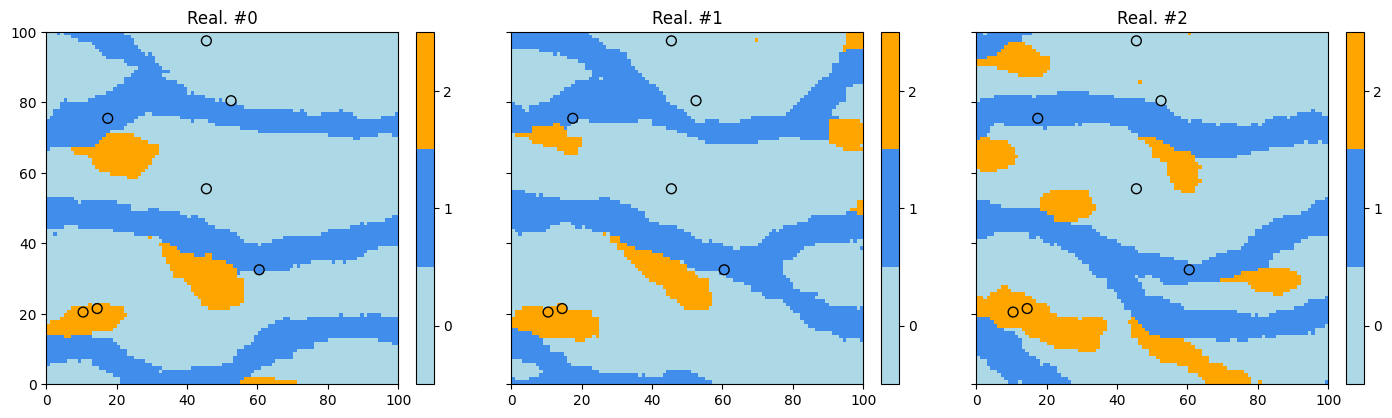

In [15]:
# Retrieve the realizations
sim = deesse_output['sim']

# Display
# -------
# Get colors for hard data (according to variable of index 3 in the point set, and color settings)
hd_col = gn.imgplot.get_colors_from_values(hd.val[3], categ=True, categVal=categ_val, categCol=categ_col) 
# # or equivalently:
# import matplotlib.colors
# hd_col=[matplotlib.colors.to_rgba(categ_col[int(v)]) for v in hd.val[3]] # colors (converted to 'rgba') 
#                                                                          # of hard data points

plt.subplots(1, 3, figsize=(17,5), sharey=True)
for i in range(3):
    plt.subplot(1, 3, i+1) # select next sub-plot
    
    # Plot realization #i
    gn.imgplot.drawImage2D(sim[i], categ=True, categVal=categ_val, categCol=categ_col) 
    # Add hard data points
    plt.scatter(hd.x(), hd.y(), marker='o', s=50, color=hd_col, edgecolors='black', linewidths=1)
    
    plt.title(f'Real. #{i}')

plt.show()

## Do some statistics on the realizations
The function `geone.img.imageCategProp(im, categ)` allows to compute the pixel-wise proportions of given categories in the list `categ` over all the variables of the image `im`. First, an image with `nreal` variables, each one corresponding to one realization, is defined (from the array of realizations) using the function `geone.img.gatherImages`.

Alternatively, the function `geone.img.imageListCategProp(im_list, categ, ind)` can be used directly to compute the pixel-wise proportions of given categories in the list `categ` over the variable of index `ind` of all the images in the list `im_list`.

In [16]:
# Gather the nreal realizations into one image
all_sim = gn.img.gatherImages(sim) # all_sim is one image with nreal variables

# Do statistics over all the realizations: compute the pixel-wise proportion for the given categories
all_sim_stats = gn.img.imageCategProp(all_sim, categ_val)

In [17]:
# Equivalently:
all_sim_stats2 = gn.img.imageListCategProp(sim, categ_val)

print("Same result ?", gn.img.isImageEqual(all_sim_stats, all_sim_stats2)) # should be True

Same result ? True


Plot the results.

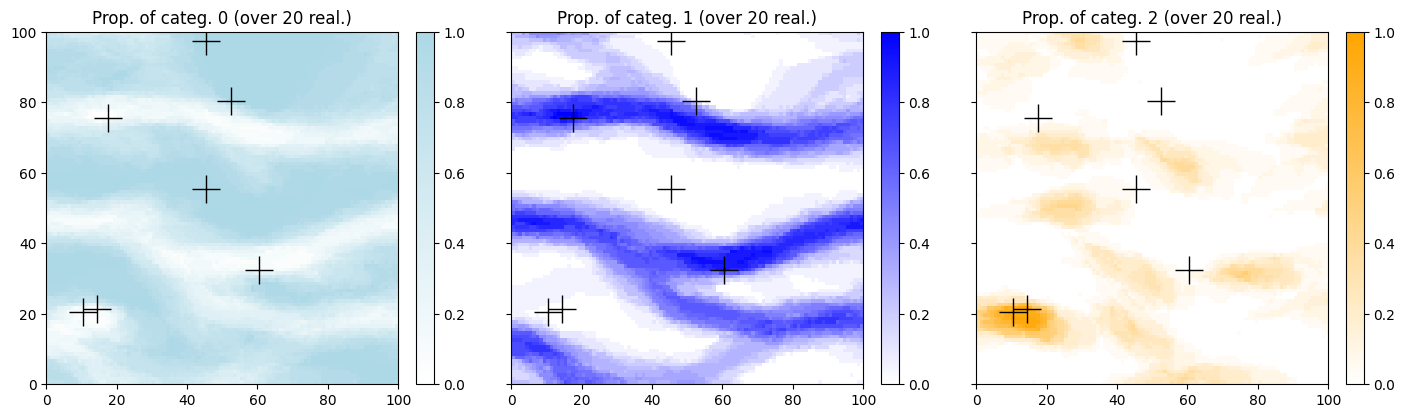

In [18]:
prop_col=['lightblue', 'blue', 'orange'] # colors for the proportion maps
cmap = [gn.customcolors.custom_cmap(['white', c]) for c in prop_col]

# Display
plt.subplots(1, 3, figsize=(17,5), sharey=True)
for i in range(3):
    plt.subplot(1, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(all_sim_stats, iv=i, cmap=cmap[i],
                           title=f'Prop. of categ. {i} (over {nreal} real.)')
    plt.plot(hd.x(), hd.y(), '+', markersize=20, c='black') # add hard data points
plt.show()

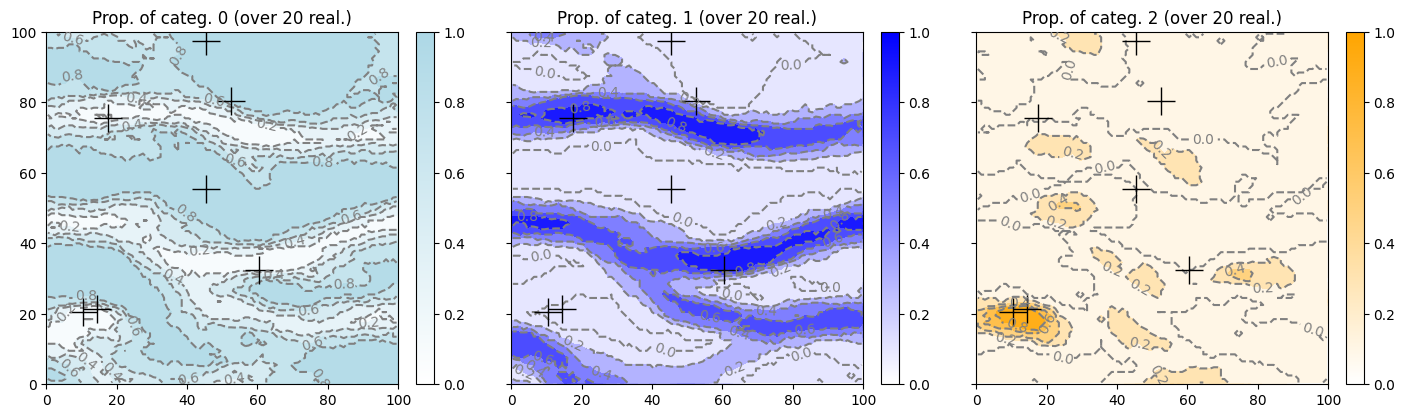

In [19]:
# Display with other styles (level (iso-value) curves)
plt.subplots(1, 3, figsize=(17,5), sharey=True)
for i in range(3):
    plt.subplot(1, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(all_sim_stats, iv=i, cmap=cmap[i], 
                           contourf=True, # fill between level (iso-value) curves
                           contour=True,  # draw level (iso-value) curves
                           levels=5, #levels=np.arange(0.0, 1.1, 0.2), # specify levels (iso-values)
                           contour_clabel=True, # draw value on level curves
                           contour_kwargs={'linestyles':'dashed', 'colors':'gray'},
                           contour_clabel_kwargs={'fontsize':10, 'inline':1},
                           title=f'Prop. of categ. {i} (over {nreal} real.)')
    plt.plot(hd.x(), hd.y(), '+', markersize=20, c='black') # add hard data points
plt.show()

## Simulations using pyramids
Enabling pyramids implies multi-resolution simulations, which can help to better reproduce the spatial structures. It consists in considering lower resolutions of the TI and the simulation grid.

See jupyter notebook `ex_deesse_16_advanced_use_of_pyramids.ipynb` for more details about pyramids.

### Parameters for pyramids 
#### Class `geone.deesseinterface.PyramidGeneralParameters` and class `geone.deesseinterface.PyramidParameters`
Using pyramids requires to define:

- General parameters (class `geone.deesseinterface.PyramidGeneralParameters`):
    - the number of pyramid levels (`npyramidLevel`) additional to the original simulation grid
    - the reduction factors along each axis direction (`kx`, `ky`, `kz`, list of length `npyramidLevel`): the integers `kx[i]`, `ky[i]`, `kz[i]` are these factors between the level `i` and the level `i+1` (the number of cells in each direction are respectively divided by these factors), the simulation grid being the level `0`, and the lowest resolution being the level `npyramidLevel`. (A factor set to zero means that no reduction is made along the corresponding direction.)
- Parameters for each variable (one variable in this example (univariate simulation)):
    - the number of levels (`nlevel`, should be equal to `npyramidLevel` above)
    - the type of pyramid (`pyramidType`), which depends on the type of the variable
    
Note: in the example below, the pyramid type is set to `categorical_auto`: one pyramid for the indicator variable of each category except one is built and used.


Note that simulation results in the pyramid (additional levels) can be retrieved in ouput; they are stored in the output dictionnary returned by a deesse simulation under the key `'sim_pyramid'`. This output is set to `None` by default. See jupyter notebook `ex_deesse_16_advanced_use_of_pyramids.ipynb` for illustrations.

In [20]:
pyrGenParams = gn.deesseinterface.PyramidGeneralParameters(
    npyramidLevel=2,                 # number of pyramid levels, additional to the simulation grid
    kx=[2, 2], ky=[2, 2], kz=[0, 0]  # reduction factors from one level to the next one
                                     #    (kz=[0, 0]: do not apply reduction along z axis)
)

pyrParams = gn.deesseinterface.PyramidParameters(
    nlevel=2,                      # number of levels
    pyramidType='categorical_auto' # type of pyramid (accordingly to categorical variable in this example)
)

### Fill the input structure for deesse and launch deesse

In [21]:
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    TI=ti,
    dataPointSet=hd,
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    pyramidGeneralParameters=pyrGenParams, # set pyramid general parameters
    pyramidParameters=pyrParams,           # set pyramid parameters for each variable
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse 
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

deesseRun: DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 19 thread(s)]
deesseRun: DeeSse run complete
Elapsed time: 7.7 sec


In [22]:
# Alternatively, using multiple processes
t1 = time.time() # start time
deesse_output2 = gn.deesseinterface.deesseRun_mp(deesse_input, nproc=4, nthreads_per_proc=4)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

deesseRun_mp: DeeSse running on 4 process(es)... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 4 thread(s)]
deesseRun_mp: DeeSse run complete (all process(es))
Elapsed time: 5.7 sec


In [23]:
# deesse_output and deesse_output2 above give same results
ok = np.all([np.all(im.val == im2.val) for im, im2 in zip(deesse_output['sim'], deesse_output2['sim'])])
## equiv.
#ok = np.all([np.all(deesse_output['sim'][i].val == deesse_output2['sim'][i].val) for i in range(nreal)])
print(f'Identical result: {ok}') # should be True

Identical result: True


### Results

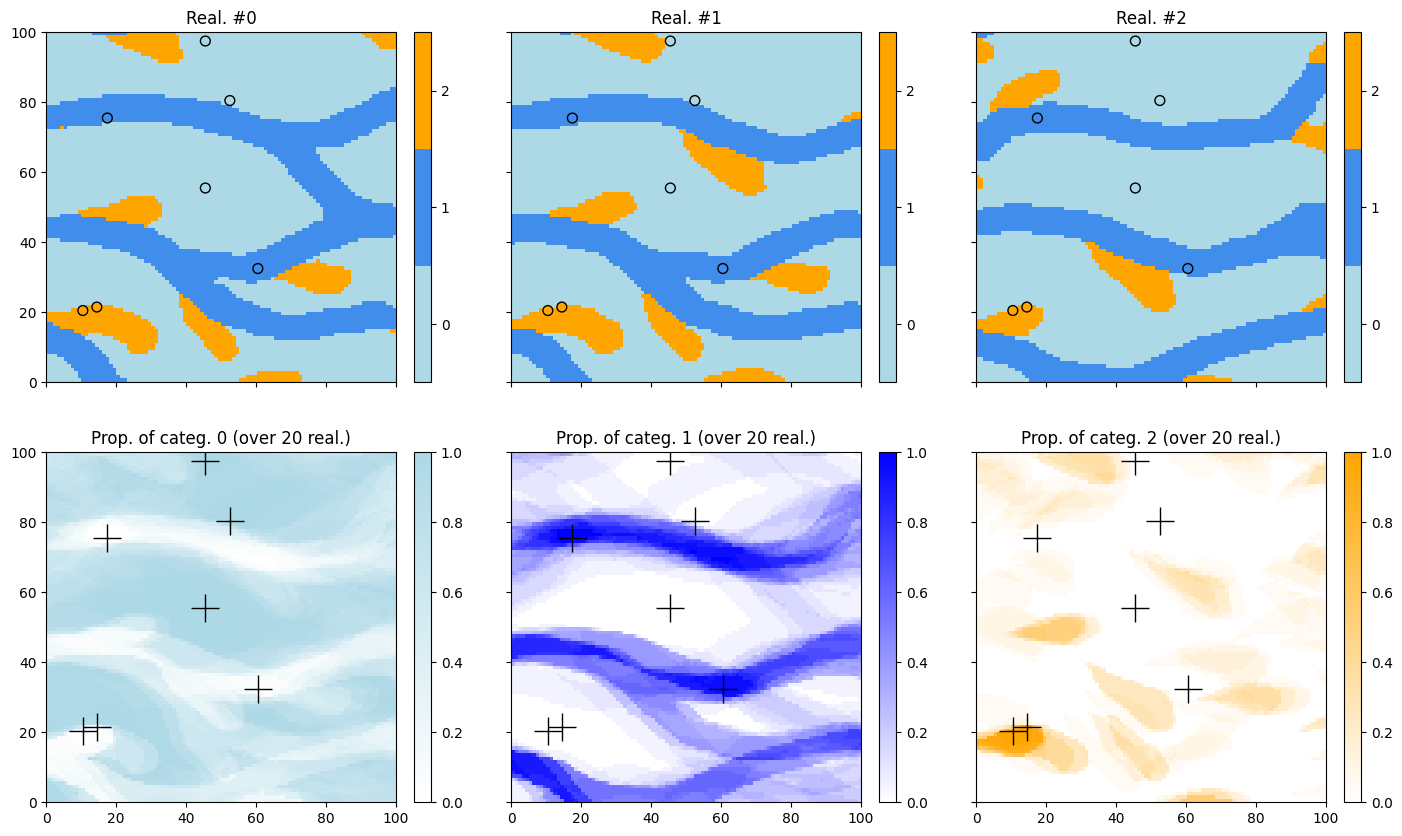

In [24]:
# Retrieve the realizations
sim = deesse_output['sim']

# Gather the nreal realizations into one image
all_sim = gn.img.gatherImages(sim) # all_sim is one image with nreal variables

# Do statistics over all the realizations: compute the pixel-wise proportion for the given categories
all_sim_stats = gn.img.imageCategProp(all_sim, [0, 1, 2])

# Display
plt.subplots(2, 3, figsize=(17,10), sharex=True, sharey=True)
for i in range(3):
    plt.subplot(2, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], categ=True, categVal=categ_val, categCol=categ_col, title=f'Real. #{i}')
    plt.scatter(hd.x(), hd.y(), marker='o', s=50, 
                color=hd_col, edgecolors='black', linewidths=1) # add hard data points
for i in range(3):
    plt.subplot(2, 3, i+4) # select next sub-plot
    gn.imgplot.drawImage2D(all_sim_stats, iv=i, cmap=cmap[i], 
                           title=f'Prop. of categ. {i} (over {nreal} real.)')
    plt.plot(hd.x(), hd.y(), '+', c='black', markersize=20) # add hard data points
plt.show()

## Simulations using pyramids (2)
Here the pyramid type is set to `categorical_to_continuous`: the pyramid is built for one continuous variable derived from the categorical variable (accounting for the connections between adjacent nodes).

In [25]:
# Deesse input
pyrParams = gn.deesseinterface.PyramidParameters(
    nlevel=2,
    pyramidType='categorical_to_continuous' # type of pyramid (accordingly to categ. variable in this example)
)

deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    TI=ti,
    dataPointSet=hd,
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    pyramidGeneralParameters=pyrGenParams,
    pyramidParameters=pyrParams,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse 
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

deesseRun: DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 19 thread(s)]
deesseRun: DeeSse run complete
Elapsed time: 8.6 sec


In [26]:
# Alternatively, using multiple processes
t1 = time.time() # start time
deesse_output2 = gn.deesseinterface.deesseRun_mp(deesse_input, nproc=4, nthreads_per_proc=4)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

deesseRun_mp: DeeSse running on 4 process(es)... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 4 thread(s)]
deesseRun_mp: DeeSse run complete (all process(es))
Elapsed time: 2.5 sec


In [27]:
# deesse_output and deesse_output2 above give same results
ok = np.all([np.all(im.val == im2.val) for im, im2 in zip(deesse_output['sim'], deesse_output2['sim'])])
#ok = np.all([np.all(deesse_output['sim'][i].val == deesse_output2['sim'][i].val) for i in range(nreal)]) # equiv.
print(f'Identical result: {ok}') # should be True

Identical result: True


### Results

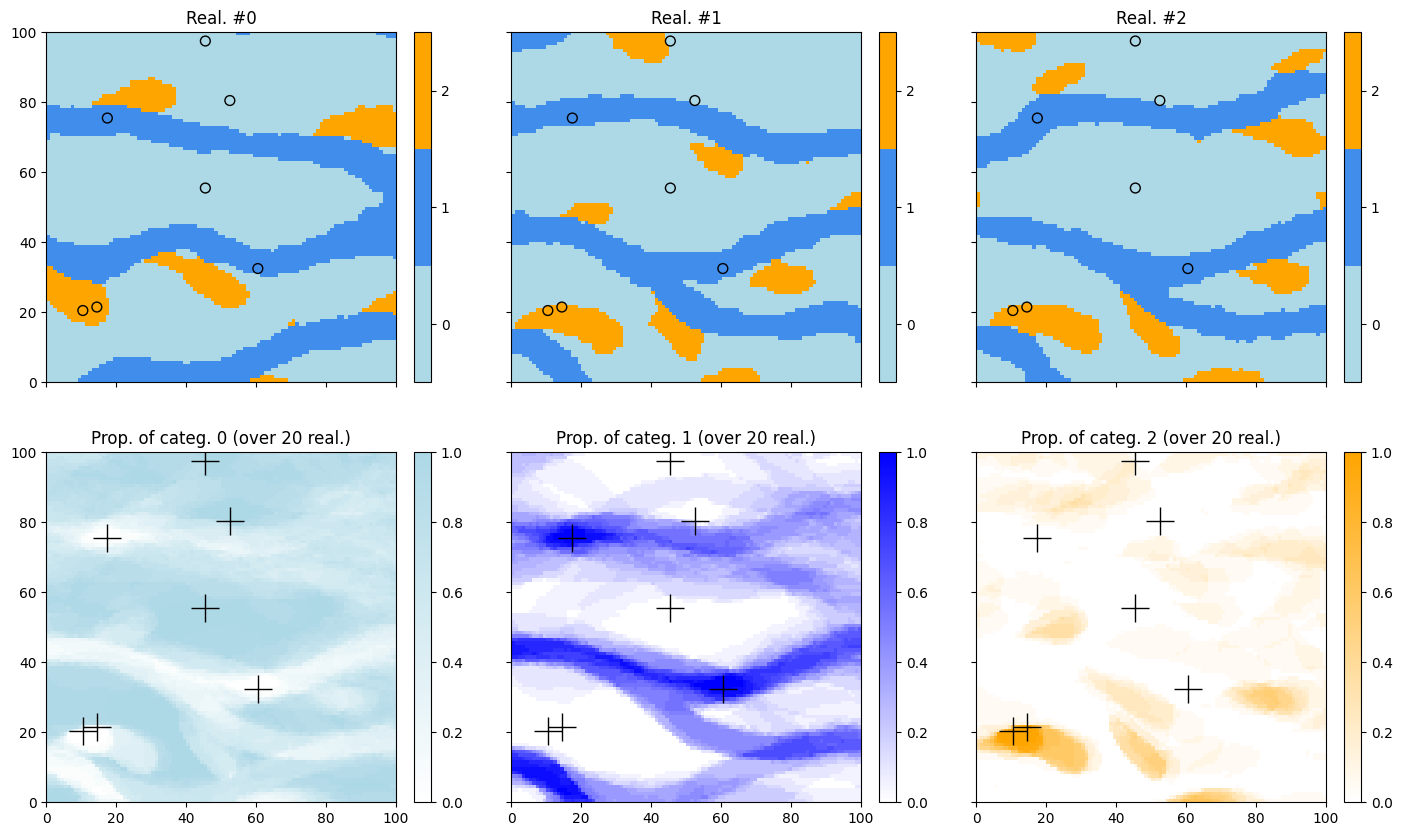

In [28]:
# Retrieve the realizations
sim = deesse_output['sim']

# Gather the nreal realizations into one image
all_sim = gn.img.gatherImages(sim) # all_sim is one image with nreal variables

# Do statistics over all the realizations: compute the pixel-wise proportion for the given categories
all_sim_stats = gn.img.imageCategProp(all_sim, [0, 1, 2])

# Display
plt.subplots(2, 3, figsize=(17,10), sharex=True, sharey=True)
for i in range(3):
    plt.subplot(2, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], categ=True, categVal=categ_val, categCol=categ_col, title=f'Real. #{i}')
    plt.scatter(hd.x(), hd.y(), marker='o', s=50, 
                color=hd_col, edgecolors='black', linewidths=1) # add hard data points
for i in range(3):
    plt.subplot(2, 3, i+4) # select next sub-plot
    gn.imgplot.drawImage2D(all_sim_stats, iv=i, cmap=cmap[i], 
                           title=f'Prop. of categ. {i} (over {nreal} real.)')
    plt.plot(hd.x(), hd.y(), '+', c='black', markersize=20) # add hard data points
plt.show()

## 3D example

In [29]:
import pyvista as pv
pv.set_jupyter_backend('static') # to get static plots within the jupyter notebook

### 3D Training image
Load from the file 'ti_3d.txt'.

In [30]:
data_dir = 'data'
filename = os.path.join(data_dir, 'ti_3d.txt')
ti3d = gn.img.readImageTxt(filename)
ti3d

*** Img object ***
name = 'data/ti_3d.txt'
(nx, ny, nz) = (100, 90, 80) # number of cells along each axis
(sx, sy, sz) = (1.0, 1.0, 1.0) # cell size (spacing) along each axis
(ox, oy, oz) = (0.5, 0.5, 0.5) # origin (coordinates of bottom-lower-left corner)
nv = 1  # number of variable(s)
varname = ['data']
val: (1, 80, 90, 100)-array
*****

### 3D plots 
The following functions can be used:

- `geone.imgplot3d.drawImage3D_volume`: 3D plot of *volumes* (smooth interpolation on the vertex of the cells)
- `geone.imgplot3d.drawImage3D_surface`: 3D plot of *surfaces* (values at cells are plotted)
- `geone.imgplot3d.drawImage3D_slice`: 3D plot of *slices* (planes)
(See jupyter notebook `ex_a_01_image_and_pointset.ipynb` for details.)

Plot in an *interactive figure* or *inline* according to the "Plotter": `pp = pv.Plotter(notebook=False)` or `pp = pv.Plotter()`.

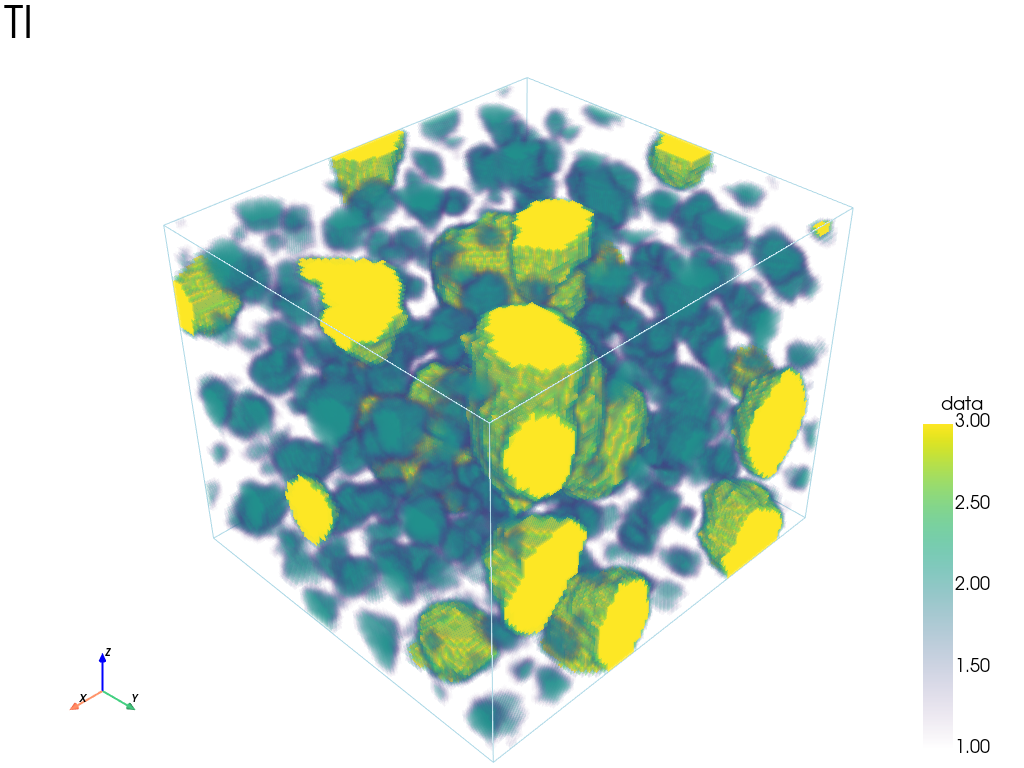

In [31]:
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive
#pp = pv.Plotter(notebook=False)
# ... inline
pp = pv.Plotter()
gn.imgplot3d.drawImage3D_volume(ti3d, plotter=pp, scalar_bar_kwargs={'vertical':True}, text='TI')
pp.show()

Customize the plot (categorical variable).

In [32]:
facies = ti3d.get_unique()
facies

array([1., 2., 3.])

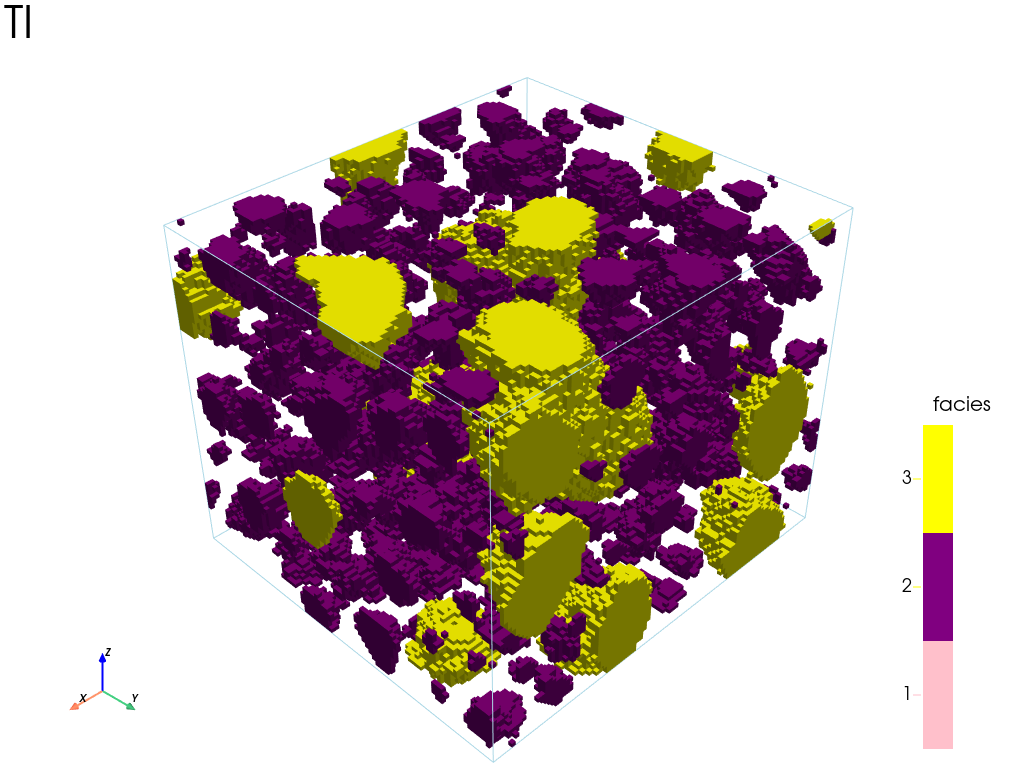

In [33]:
# Customization of the output: 
#    - set mode in "categorical variable" (categ=True), and
#        - specify list of category values (categVal)
#        - specify color for each category value (categCol)
#        - specify which categories are "active" for display (categActive)
#    - set title for the scalar bar
#    - ...
categVal = [1, 2, 3] # list of category values / facies
categCol = ['pink', 'purple', 'yellow'] # colors for each category / facies

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive
#pp = pv.Plotter(notebook=False)
# ... inline
pp = pv.Plotter()
gn.imgplot3d.drawImage3D_surface(
    ti3d, 
    plotter=pp, categ=True, categVal=categVal, categCol=categCol,
    categActive=[False, True, True], # display only category value (in categVal) with True
    alpha=1.0, # transparency (alpha channel)
    scalar_bar_kwargs={'title':'facies', 'title_font_size':20, 'vertical':True},
    text='TI'
)
pp.show()

### 3D Simulation grid
Define the simulation grid (number of cells in each direction, cell unit, origin).

In [34]:
nx, ny, nz = 60, 60, 60          # number of cells
sx, sy, sz = ti.sx, ti.sy, ti.sz # cell unit
ox, oy, oz = 0.0, 0.0, 0.0       # origin (corner of the "first" grid cell)

### Hard data (point set)

Set some conditioning data.

In [35]:
npt = 3 # number of points
nv = 4  # number of variables including x, y, z coordinates
varname = ['x', 'y', 'z', 'code'] # list of variable names
v = np.array([
    [ 15.5,  45.5, 50.5, 1], # x, y, z, code: 1st point
    [ 47.5,  10.5, 48.5, 2], # ...
    [ 27.5,  28.5,  5.5, 3]
    ]).T # variable values: (nv, npt)-array
hd = gn.img.PointSet(npt=npt, nv=nv, varname=varname, val=v)

Plot the hard data points in the simulation grid.

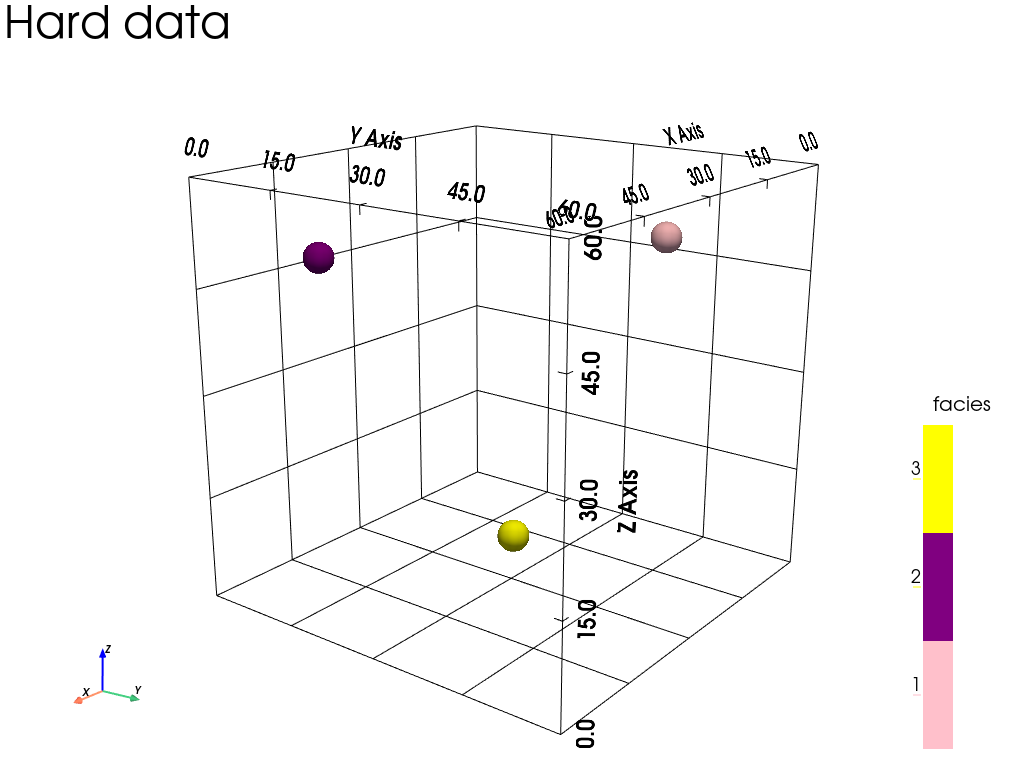

In [36]:
# Get colors for hard data (according to variable of index 3 in the point set, and color settings)
hd_col = gn.imgplot.get_colors_from_values(hd.val[3], categ=True, categVal=categVal, categCol=categCol) 

# Set points to be plotted
hd_points = pv.PolyData(hd.val[:3].T) # position of the points
hd_points['colors'] = hd_col # colors for the points

# Set an image with simulation grid geometry defined above, and no variable
im_empty = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=0)

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive
#pp = pv.Plotter(notebook=False)
# ... inline
pp = pv.Plotter()

# Plot empty simulation grid and specify colors
gn.imgplot3d.drawImage3D_empty_grid(
    im_empty, 
    plotter=pp, 
    categ=True, categVal=categVal, categCol=categCol,
    show_bounds=True, bounds_kwargs={'grid':True},
    scalar_bar_kwargs={'title':'facies', 'title_font_size':20, 'vertical':True},
    text='Hard data'
)

# Add hard data points
pp.add_mesh(hd_points, rgb=True, point_size=32., render_points_as_spheres=True) # add data points

# Define cpos by first plotting interactively and then retrieving cpos (pp.show(return_cpos=True)
cpos = [(182.45555265062882, 144.55482888484926, 92.77455190519737),
        (30.0, 30.0, 30.0),
        (-0.24740542241904603, -0.19124554011188336, 0.9498503568167818)] 
pp.show(cpos=cpos)

### Do a conditional simulation with deesse (3D, with pyramids)

In [37]:
# Set input for deesse
pyrGenParams = gn.deesseinterface.PyramidGeneralParameters(
    npyramidLevel=2,
    kx=[2, 2], ky=[2, 2], kz=[2, 2]
)

pyrParams = gn.deesseinterface.PyramidParameters(
    nlevel=2,
    pyramidType='categorical_auto'
)

nreal = 1

deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    TI=ti3d,
    dataPointSet=hd,
    nneighboringNode=24,
    distanceThreshold=0.02,
    maxScanFraction=0.02,
    pyramidGeneralParameters=pyrGenParams,
    pyramidParameters=pyrParams,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

deesseRun: DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 19 thread(s)]
deesseRun: DeeSse run complete
Elapsed time: 9.3 sec


### Plot the results

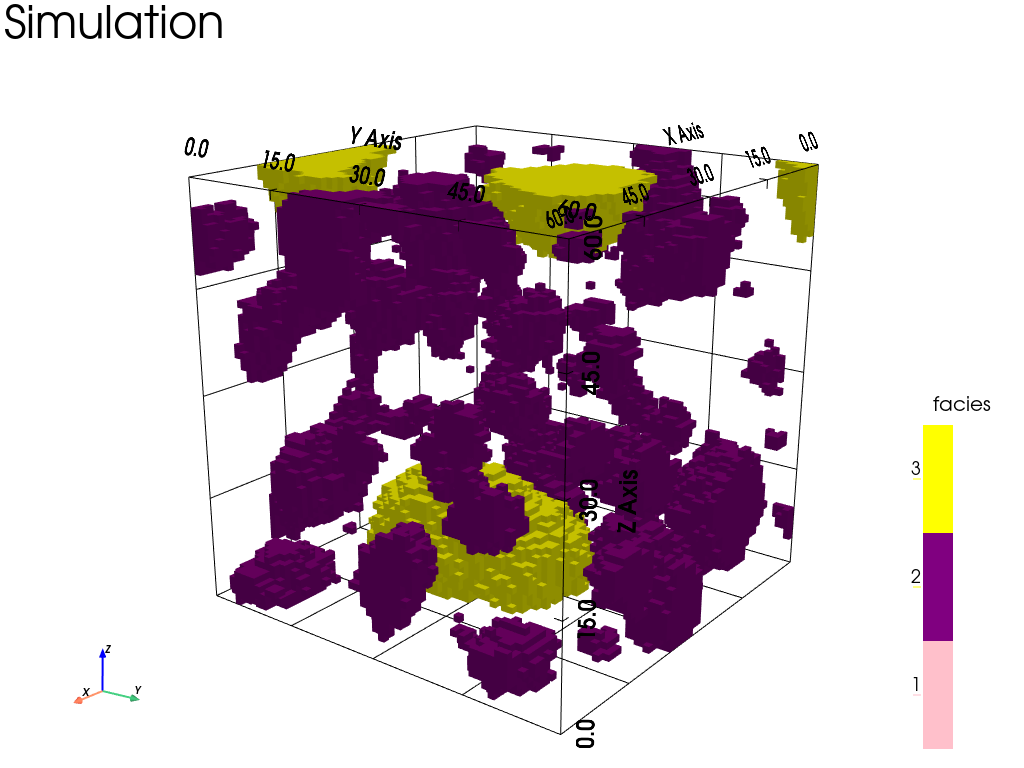

In [38]:
# Retrieve the realization
sim = deesse_output['sim']

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive
#pp = pv.Plotter(notebook=False)
# ... inline
pp = pv.Plotter()
gn.imgplot3d.drawImage3D_surface(sim[0], plotter=pp,
    categ=True,
    categVal=categVal,
    categCol=categCol,
    categActive=[False, True, True], # display only category value (in categVal) with True
    alpha=1.0, # transparency (alpha channel)
    show_bounds=True, bounds_kwargs={'grid':True},
    scalar_bar_kwargs={'title':'facies', 'title_font_size':20, 'vertical':True},
    text='Simulation')
pp.show(cpos=cpos)

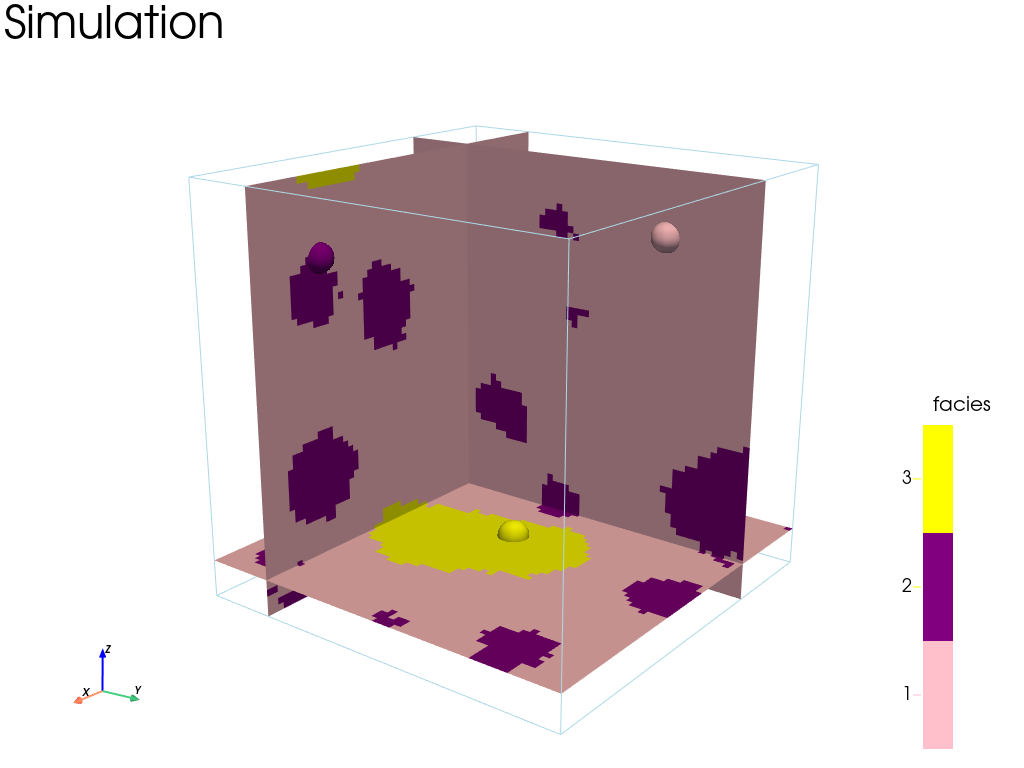

In [39]:
# Some slices through the conditioning data points
# ------------------------------------------------
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive
#pp = pv.Plotter(notebook=False)
# ... inline
pp = pv.Plotter()
gn.imgplot3d.drawImage3D_slice(
    sim[0], 
    plotter=pp, 
    slice_normal_x=hd.x()[0], # slice orthogonal to x-axis, going through the data point 0
    slice_normal_y=hd.y()[1], # slice orthogonal to y-axis, going through the data point 1
    slice_normal_z=hd.z()[2], # slice orthogonal to z-axis, going through the data point 2
    categ=True, categVal=categVal, categCol=categCol,
    alpha=1.0, # transparency (alpha channel)
    scalar_bar_kwargs={'title':'facies', 'title_font_size':20, 'vertical':True},
    text='Simulation'
)

pp.add_mesh(hd_points, rgb=True, point_size=32., render_points_as_spheres=True) # add data points

pp.show(cpos=cpos)